<a href="https://colab.research.google.com/github/Codes-of-Hermit/Finance_codes/blob/main/Stock_Portfolio_Optimization_with_Efficient_Frontier_Visualization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Enter the investment amount: 1000
Added AAPL: Beta=1.25, EPS=6.44, Current Ratio=1.037
Added MSFT: Beta=0.893, EPS=11.53, Current Ratio=1.242
Added GOOGL: Beta=1.01, EPS=6.53, Current Ratio=2.149
Added AMZN: Beta=1.142, EPS=3.56, Current Ratio=1.072
Skipped FB due to missing data
Added TSLA: Beta=2.318, EPS=3.91, Current Ratio=1.716
Added NFLX: Beta=1.257, EPS=14.43, Current Ratio=1.068
Added NVDA: Beta=1.694, EPS=1.71, Current Ratio=3.529
Added PYPL: Beta=1.428, EPS=3.97, Current Ratio=1.278
Added INTC: Beta=1.06, EPS=0.97, Current Ratio=1.566
Added ADBE: Beta=1.269, EPS=11.1, Current Ratio=1.164
Added CSCO: Beta=0.845, EPS=2.96, Current Ratio=0.895
Added PEP: Beta=0.531, EPS=6.64, Current Ratio=0.86
Added ORCL: Beta=1.008, EPS=3.7, Current Ratio=0.715
Added IBM: Beta=0.718, EPS=8.82, Current Ratio=1.132
Added QCOM: Beta=1.297, EPS=7.5, Current Ratio=2.65
Added AVGO: Beta=1.182, EPS=23.24, Current Ratio=1.254
Added TXN: Beta=0.991, EPS=6.43, Current Ratio=4.911
Added AMD: Beta=1.686, 

[*********************100%%**********************]  4 of 4 completed


Optimized Portfolio Return: 35.53%
Optimized Portfolio Risk: 31.18%
Optimized Portfolio Weights: [0.6152871  0.16087936 0.         0.22383353]


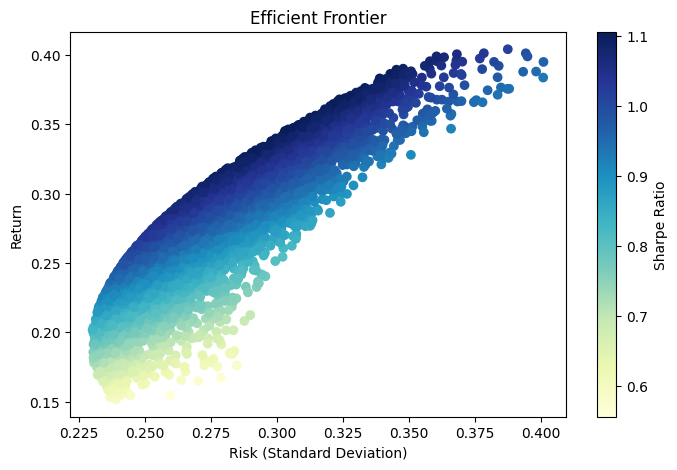

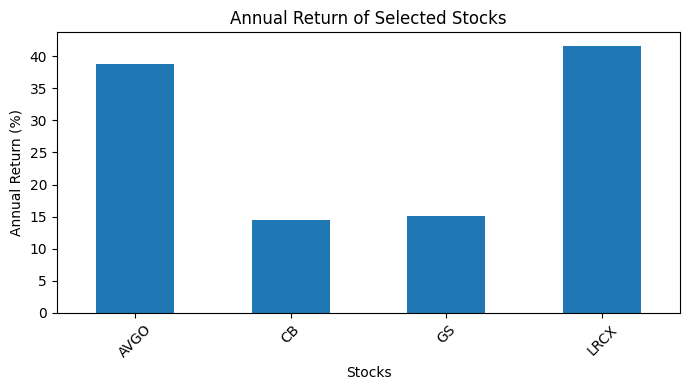

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from datetime import datetime, timedelta

def fetch_data(tickers, start_date, end_date):
    try:
        data = yf.download(tickers, start=start_date, end=end_date)['Adj Close']
        if data.empty:
            raise ValueError("No data retrieved for the tickers.")
        return data
    except Exception as e:
        print(f"Error fetching data: {e}")
        return None

def calculate_annual_return_and_covariance(data):
    daily_returns = data.pct_change().dropna()
    annual_returns = daily_returns.mean() * 252
    annual_covariance = daily_returns.cov() * 252
    return annual_returns, annual_covariance

def portfolio_performance(weights, returns, covariance):
    portfolio_return = np.sum(weights * returns)
    portfolio_risk = np.sqrt(np.dot(weights.T, np.dot(covariance, weights)))
    return portfolio_return, portfolio_risk

def negative_sharpe_ratio(weights, returns, covariance, risk_free_rate=0.01):
    p_return, p_risk = portfolio_performance(weights, returns, covariance)
    sharpe_ratio = (p_return - risk_free_rate) / p_risk
    return -sharpe_ratio

def optimize_portfolio(returns, covariance, num_assets):
    init_guess = num_assets * [1. / num_assets,]
    constraints = ({'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1})
    bounds = tuple((0, 1) for asset in range(num_assets))
    optimized = minimize(negative_sharpe_ratio, init_guess, args=(returns, covariance), method='SLSQP', bounds=bounds, constraints=constraints)
    return optimized

def display_portfolio_performance(weights, returns, covariance):
    p_return, p_risk = portfolio_performance(weights, returns, covariance)
    print(f"Optimized Portfolio Return: {p_return * 100:.2f}%")
    print(f"Optimized Portfolio Risk: {p_risk * 100:.2f}%")
    print(f"Optimized Portfolio Weights: {weights}")

def plot_efficient_frontier(returns, covariance, num_portfolios=10000, risk_free_rate=0.01):
    num_assets = len(returns)
    results = np.zeros((3, num_portfolios))
    for i in range(num_portfolios):
        weights = np.random.random(num_assets)
        weights /= np.sum(weights)
        p_return, p_risk = portfolio_performance(weights, returns, covariance)
        results[0, i] = p_risk
        results[1, i] = p_return
        results[2, i] = (p_return - risk_free_rate) / p_risk
    plt.figure(figsize=(8, 5))
    plt.scatter(results[0], results[1], c=results[2], cmap='YlGnBu', marker='o')
    plt.colorbar(label='Sharpe Ratio')
    plt.title('Efficient Frontier')
    plt.xlabel('Risk (Standard Deviation)')
    plt.ylabel('Return')
    plt.show()

def select_companies_based_on_metrics():
    tickers = 'AAPL MSFT GOOGL AMZN FB TSLA NFLX NVDA PYPL INTC ADBE CSCO PEP ORCL IBM QCOM AVGO TXN AMD TSM LRCX MU ASML ADI NXPI MCHP SWKS TER KLAC XLNX STM MPWR INTU CRM SAP ADP NOW TEAM WDAY PAYC CDNS ANSS MSI ZBRA TTD VEEV DDOG OKTA ZS MDB PLTR NET SNOW CRWD DOCU TWLO SPOT U ROKU FSLY SHOP ETSY SQ PYPL MA V AXP COF DFS SYF ALLY ALL HIG PGR TRV CB CINF AIG L PRU MET UNM LNC VOYA SIVB CMA MTB WFC BAC C JPM MS GS BK NTRS STT TFC RF KEY FITB CFG HBAN ZION PNC USB WAL WAFD SBNY FRC SCHW ETFC AMTD IBKR LPLA NDAQ CBOE ICE MKTX CME AFL'.split()
    metrics = []
    for ticker in tickers:
        stock = yf.Ticker(ticker)
        info = stock.info
        try:
            beta = info.get('beta', np.nan)
            eps = info.get('trailingEps', np.nan)
            current_ratio = info.get('currentRatio', np.nan)

            if pd.notna(beta) and pd.notna(eps) and pd.notna(current_ratio):
                metrics.append({
                    'ticker': ticker,
                    'beta': beta,
                    'eps': eps,
                    'current_ratio': current_ratio
                })
                print(f"Added {ticker}: Beta={beta}, EPS={eps}, Current Ratio={current_ratio}")
            else:
                print(f"Skipped {ticker} due to missing data")
        except Exception as e:
            print(f"Error fetching data for {ticker}: {e}")
    df_metrics = pd.DataFrame(metrics).dropna()
    selected_companies = df_metrics.sort_values(by=['eps', 'beta', 'current_ratio'], ascending=[False, False, True]).head(4)
    return selected_companies['ticker'].tolist()

if __name__ == "__main__":
    investment_amount = float(input("Enter the investment amount: "))
    selected_tickers = select_companies_based_on_metrics()

    if selected_tickers:
        print(f"Selected Tickers: {selected_tickers}")

        start_date = '2017-01-01'
        end_date = (datetime.today() - timedelta(days=1)).strftime('%Y-%m-%d')
        data = fetch_data(selected_tickers, start_date, end_date)

        if data is not None and not data.empty:
            returns, covariance = calculate_annual_return_and_covariance(data)
            optimized = optimize_portfolio(returns, covariance, len(selected_tickers))
            display_portfolio_performance(optimized.x, returns, covariance)
            plot_efficient_frontier(returns, covariance)

            fig, ax = plt.subplots(figsize=(7, 4))
            annual_returns = returns * 100
            annual_returns.plot(kind='bar', ax=ax)
            ax.set_title('Annual Return of Selected Stocks')
            ax.set_ylabel('Annual Return (%)')
            ax.set_xlabel('Stocks')
            plt.xticks(rotation=45)
            plt.tight_layout()
            plt.show()
        else:
            print("No data available for the selected tickers.")
    else:
        print("No valid tickers selected.")
